In [383]:
import os
import librosa
import numpy as np
import matplotlib as plt
import scipy.spatial.distance as dist


In [384]:
def load_sound_files(dir='data/'):
    representative_sounds = {}
    digit_sounds = {}
    digit_users = {}

    for filename in os.listdir(dir):
        if filename.endswith('.wav'):
            codes = filename.split('.')[0].split('-')
            user = codes[1] + '-' + codes[2]
            digit = codes[0]
            file_path = os.path.join(dir, filename)
            audio_data, _ = librosa.load(file_path)
            if codes[1] == '38' and codes[2] == '20':
                representative_sounds[digit] = audio_data
            else:
                if digit not in digit_sounds:
                    digit_sounds[digit] = []
                    digit_users[digit] = []
                digit_sounds[digit].append(audio_data)
                digit_users[digit].append(user)

    return representative_sounds, digit_sounds, digit_users


In [385]:
rep_sounds, digit_sounds, digit_users = load_sound_files()

In [386]:
def plot_mel_spec(x): 
    mel_spec = librosa.feature.melspectrogram(y=x, n_mels=40, n_fft=2048, hop_length=512)
    #n_mels=40 imamo 40 elemenata u vektoru za svaku kolonu
    #trazimo rastojanje izmedju svake kolone
    log_mel_spec_x = np.log(mel_spec)
    fig,ax = plt.pyplot.subplots(figsize=(9,5))
    ax.imshow(log_mel_spec_x,origin='lower',interpolation='nearest')

    plt.pyplot.ylabel("Feature dimensions")
    plt.pyplot.xlabel("Frames")

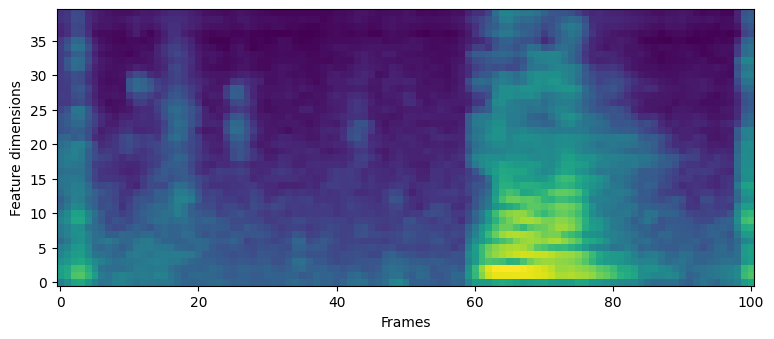

In [387]:
plot_mel_spec(rep_sounds['0'])

In [388]:
def plot_mfcc(audio_data):
    mfccs = librosa.feature.mfcc(y=audio_data, n_fft=2048, hop_length=512, n_mfcc=25)
    fig, ax = plt.pyplot.subplots(figsize=(10, 10))
    ax.imshow(mfccs, origin='lower', interpolation='nearest')
    plt.pyplot.xlabel('Frames')
    plt.pyplot.ylabel('MFCC Coefficients')

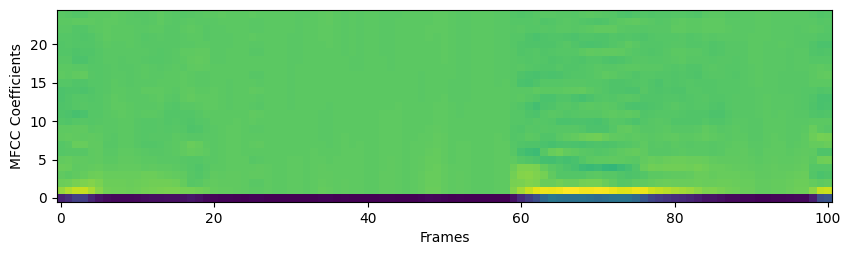

In [389]:
plot_mfcc(rep_sounds['0'])

In [390]:
def dp(dist_mat):
    N, M = dist_mat.shape
    
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    #cost_mat = cost_mat[1:, 1:]
    return cost_mat[N-1, M-1] / (N + M), path[::-1]

In [391]:
def all_preprocessing(sound, n_mels=42, n_mfcc=25, order=12):
        mel_spec = librosa.feature.melspectrogram(y=sound, n_fft=2048, hop_length=512, n_mels=n_mels)
        log_mel_spec = np.log(mel_spec + 1e-9)
        log_mel_spec = log_mel_spec.T

        mfccs = librosa.feature.mfcc(y=sound, n_fft=2048, hop_length=512, n_mfcc=n_mfcc)
        mfccs = mfccs.T

        lpc_coeffs = librosa.lpc(sound, order=order)

        return log_mel_spec, mfccs, lpc_coeffs

In [392]:
def preprocess_ref_sounds(ref_sounds):
        preprocessed_refs = {}
        for digit, ref_sound in ref_sounds.items():
            log_mel_spec, mfccs, lpc_coeffs = all_preprocessing(ref_sound)
            preprocessed_refs[digit] = (log_mel_spec, mfccs, lpc_coeffs)

        return preprocessed_refs


In [393]:
def mel_preprocessing(sound, n_mels=42):
        mel_spec = librosa.feature.melspectrogram(y=sound, n_fft=2048, hop_length=512, n_mels=n_mels)
        log_mel_spec = np.log(mel_spec + 1e-9)
        log_mel_spec = log_mel_spec.T

        return log_mel_spec

In [394]:
def compare_and_predict(test_sound,real_digit, threshold):
        dtw_costs = {}
        dtw_paths = {}                
        log_mel_spec, mfccs, lpc_coeffs = all_preprocessing(test_sound)
        ref_preprocessed = preprocess_ref_sounds(rep_sounds)
        
        log_mel_spec = mel_preprocessing(test_sound)
        min_cost = 100000
        min_digit = None
      
        for digit, ref_sound in ref_preprocessed.items():
            dist_mat = dist.cdist(log_mel_spec,ref_sound[0],"cosine")
            cost,path = dp(dist_mat)
            if cost < min_cost:
                min_cost = cost
                min_digit = digit

        if min_cost > threshold:
            print('Unknown sound')
            return
        else:
            print(f'Predicted digit: {min_digit} and real digit is: {real_digit}')
            
        for digit, ref_sound in ref_preprocessed.items():
            dtw_costs[digit] = []
            
            dist_mat_1 = dist.cdist(log_mel_spec,ref_sound[0],"cosine")
            cost1,path1 = dp(dist_mat_1)
            dist_mat_2 = dist.cdist(mfccs,ref_sound[1],"cosine")
            cost2,path2 = dp(dist_mat_2)
            dist_mat_3 = dist.cdist(lpc_coeffs.reshape(-1, 1), ref_sound[2].reshape(-1, 1),"euclidean")
            cost3,path3 = dp(dist_mat_3)
      
            dtw_costs[digit] += [cost1, cost2, cost3]
            dtw_paths[digit] += [path1, path2, path3]

        
        min_cost1, min_cost2, min_cost3 = 100000, 100000, 100000
        min_digit1, min_digit2, min_digit3 = None, None, None
        
        for digit, costs in dtw_costs.items():
            if costs[0] < min_cost1:
                min_cost1 = costs[0]
                min_digit1 = digit
            if costs[1] < min_cost2:
                min_cost2 = costs[1]
                min_digit2 = digit
            if costs[2] < min_cost3:
                min_cost3 = costs[2]
                min_digit3 = digit

        print(f'Log Mel spectrogram min DTW distances: {min_cost1}, for digit {min_digit1}')
        print(f'MFCC min DTW distances: {min_cost2}, for digit {min_digit2}')
        print(f'LPC min DTW distances: {min_cost3}, for digit {min_digit3}')
        

In [395]:
compare_and_predict(digit_sounds['1'][2], real_digit='1',threshold=0.05)

Predicted digit: 1 and real digit is: 1
Log Mel spectrogram min DTW distances: 0.017115285694152525, for digit 1
MFCC min DTW distances: 0.009570377366560997, for digit 1
LPC min DTW distances: 0.08561385136384231, for digit 9


In [396]:
x,_=librosa.load('data/you-call-that-fun.wav')
compare_and_predict(x, real_digit='7',threshold=0.05)

Unknown sound


In [397]:
def find_sound_partner(sounds_dict, users_dict):
        users_scores = {}
        ref_preprocessed = preprocess_ref_sounds(rep_sounds)
        for digit, ref_sound in ref_preprocessed.items():
            for i, sample_sound in enumerate(sounds_dict[digit]):
                if users_dict[digit][i] not in users_scores:
                    users_scores[users_dict[digit][i]] = 0
                log_mel_spec = mel_preprocessing(sample_sound)
                dist_mat = dist.cdist(log_mel_spec,ref_sound[0],"cosine")
                cost,path = dp(dist_mat)
                users_scores[users_dict[digit][i]] += cost

        min_score = 100000
        min_user = None

        for user, score in users_scores.items():
            if score < min_score:
                min_score = score
                min_user = user

        print(f'User with the most similar voice is: {min_user}')
        return min_user

In [398]:
find_sound_partner(digit_sounds, digit_users)

User with the most similar voice is: 106-21


'106-21'